# Deep dive into `IPPy`

`IPPy` is a simple library, developed by me specifically for this course (and to support me during my experiments for papers). It includes multiple modules:

- `nn`: contains functions to easy define complex neural network models, such as UNet, ViT, and others, with a flexible design.
- `solvers`: implements a few optimization algorithms already discussed in the first module of this course, such as the `ChambollePock` algorithm for TV minimization, the `SGP` algorithm for smoothed-TV regularization, and others.
- `operators`: implements multiple operators (we will check some of them below) specifically designed to work well with pytorch tensors. Not only they are developed so that they can efficiently work with batched, multidimensional data, but they also implement gradient tracking, useful to backpropagate the gradient back from the output to the input of the inverse process. This is useful in applications such as Algorithm Unrolling or Deep Generative Prior (DGP).

The code for `IPPy` can be simply dowloaded from my Github page at: [https://github.com/devangelista2/IPPy](https://github.com/devangelista2/IPPy).

```{image} /imgs/IPPy-structure.png
:width: 600px
:align: center
```

## Introduction and requirements

IPPy is built upon a few commonly used libraries for tensor manipulation, linear algebra, Computed Tomography, neural networks and visualization. Here is a list of the libraries you need to install to make IPPy run smoothly:

- `numpy`
- `numba`
- `astra-toolbox`
- `scikit-image`
- `PIL`
- `matplotlib`

Moreover, it is **required** to have access to a cuda GPU, both for training neural network models and for fast Computed Tomography simulations. In particular, some `astra-toolbox` operators won't work if CUDA is not available.

```{warning}
In case one has no access to a `cuda` GPU, it can be also installed the `cpu` version of `astra-toolbox` (a few geometries won't work in this setup, but it is ok for the topic of this course).
```

Basically all the required libraries can be simply install with the command:

```
pip install <PACKAGE_NAME>
```

or by:

```
conda install <PACKAGE_NAME>
```

The only exception is `astra-toolbox`, whose installation instruction can be found in its official documentation website, at: [https://astra-toolbox.com](https://astra-toolbox.com).

### Standard tensors

As already remarked, all the `IPPy` functions are thought to work with Pytorch tensors. In particular, with what is called a **standardized pytorch tensor**, that is a tensor with the following properties:

- Its shape is `(N, c, n_x, n_y)`, where `c` is either equal to 1 or 3.
- It is normalized so that its maximum is 1 and its minimum is 0.
- Its `ndtype` is `float32`.

While most of the functions still works if some of these properties are not satisfied, the obtained results could be artificious.

Given that, we can now move to the core of the `IPPy` package: the `operators` module.

## The `operators` module

An `IPPy` operator is a Python class that simulates the application of a corruption matrix $K$ to an input tensor $x$. The basic `Operator` class is defined as follows:

In [1]:
import torch

class Operator:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """Applies operator using PyTorch autograd wrapper"""
        return OperatorFunction.apply(self, x)

    def __matmul__(self, x: torch.Tensor) -> torch.Tensor:
        """Matrix-vector multiplication"""
        return self.__call__(x)

    def T(self, y: torch.Tensor) -> torch.Tensor:
        """Transpose operator (adjoint)"""
        device = y.device
        # Apply adjoint to the batch
        return self._adjoint(y).to(device).requires_grad_(True)

    def _matvec(self, x: torch.Tensor) -> torch.Tensor:
        """Apply the operator to a single (c, h, w) tensor"""
        raise NotImplementedError

    def _adjoint(self, y: torch.Tensor) -> torch.Tensor:
        """Apply the adjoint operator to a single (c, h, w) tensor"""
        raise NotImplementedError

As you can see, the `Operator` class implements a few basic methods, such as `__call__`, `__matmul__` and `T` that should not be modified by the user, and two methods that are specific for the kind of operator and should be customized: `_matvec` and `_adjoint`. 

As you can easily imagine, the `_matvec` method describes how the operator should corrupt the input tensor, i.e. how to compute the forward $K(x)$. Similarly, the `_adjoint` method represents the application of the transposed of the operator, i.e. $K^T(y)$. 

Note that, thanks to the support of the `OperatorFunction`, each operator needs to be defined only on a tensor of shape `(c, n_x, n_y)`, and it will automatically handle the parallelization over the batch dimension `N` of the input tensor.  

### Example: the Negative operator

As an example, let's build a **negative** operator, i.e. an operator that reverse the colors of the input image, based on the `Operator` class in `IPPy`. We will consider an image from Mayo's dataset from the previous notebook as an example.

In [2]:
#-----------------
# This is just for rendering on the website
import os
import sys
sys.path.append("..")
#-----------------

from IPPy import operators

class NegativeOperator(operators.Operator):
    def _matvec(self, x):
        """
        Since x is a standardized Tensor (i.e. its in the range [0, 1]), the negative image
        can be obtained by simply computing y = 1 - x.
        """
        return 1 - x
    
    def _adjoint(self, y):
        """
        The adjoint of the negative operator is again x = 1 - y.
        """
        return 1 - y

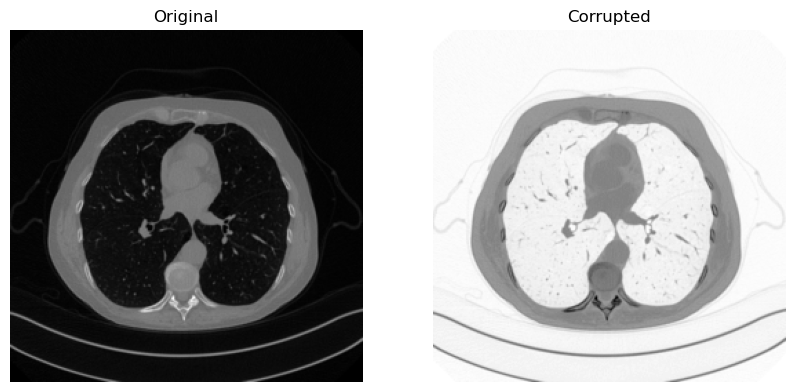

In [3]:
import glob

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class MayoDataset(Dataset):
    def __init__(self, data_path, data_shape):
        super().__init__()

        self.data_path = data_path
        self.data_shape = data_shape

        # We expect data_path to be like "./data/Mayo/train" or "./data/Mayo/test"
        self.fname_list = glob.glob(f"{data_path}/*/*.png")

    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        # Load the idx's image from fname_list
        img_path = self.fname_list[idx]

         # To load the image as grey-scale
        x = Image.open(img_path).convert("L")

        # Convert to numpy array -> (512, 512)
        x = np.array(x) 

        # Convert to pytorch tensor -> (1, 512, 512) <-> (c, n_x, n_y)
        x = torch.tensor(x).unsqueeze(0)

        # Resize to the required shape
        x = transforms.Resize(self.data_shape)(x) # (1, n_x, n_y)

        # Normalize in [0, 1] range
        x = (x - x.min()) / (x.max() - x.min())

        return x
    
# Get sample image
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)
x = test_data[0].unsqueeze(0)

# Define corruption operator
K = NegativeOperator()

# Compute negative of x
y = K(x)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(y.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')
plt.show()

### Built-in operators

Clearly, `IPPy` implements a few built-in operators commonly used in literature. At this moment, it has built-in support for:

- **Computed Tomography** operator: implementing the forward and backward acquisition of a general Computed Tomography projector,
- **Image Deblurring** operator: implementing a general Blurring and Deblurring operator, taking as input either a general blurring kernel or the parameters for a built-in Gaussian kernel (specifying the variance and the kernel size), and a Motion kernel (specifying the motion angle and the kernel size);
- **Downscaling** operator: which downscale the input image by a given factor.;
- **Gradient** operator: mostly used to implement TV-based reconstruction algorithm.

But more operators will be added in the future.

Let's see how to blur an image with a MotionBlur kernel of specified parameters.

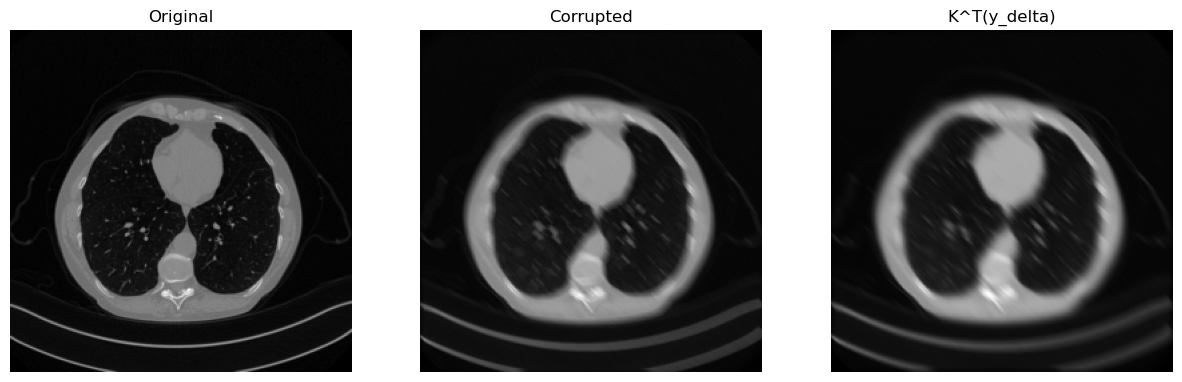

In [4]:
from IPPy import operators, utilities

# Get sample image from MayoDataset
x_true = test_data[10].unsqueeze(0)

# Define MotionBlur operator (with a 45° angle)
K = operators.Blurring(img_shape=(256, 256), 
                       kernel_type="motion", 
                       kernel_size=7, 
                       motion_angle=45,)

# Compute blurred version of x_true
y = K(x_true)

# Add noise
y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

# Compute (just for the sake of the explanation, the transpose)
x_T = K.T(y_delta)

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_T.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('K^T(y_delta)')
plt.show()

Feel free to test different operators to see how they work.

### Backpropagate through `IPPy` operators

A great feature of `IPPy` operators is that they allow backpropagating through them by the usual Pytorch backpropagation. For example, consider the following objective function:

$$
f(x) = || Kx - y^\delta ||_2^2,
$$

and note that:

$$
\nabla_x f(x) = 2 * K^T(Kx - y^\delta).
$$

This operation can be automatically performed for `IPPy` operators via the `.backward()` method in Pytorch:

In [5]:
# Define x_true and track its gradient
x_true = test_data[10].unsqueeze(0)
x_true.requires_grad_(True)

# Compute y_delta with no gradient tracking
with torch.no_grad():
    y = K(x_true)
    y_delta = y + utilities.gaussian_noise(y, noise_level=0.005)

# Example: compute f(x)
f = torch.sum(torch.square(K(x_true) - y_delta))

# Compute gradient
f.backward()
grad_x = x_true.grad
print(f"Grad_x = {torch.norm(grad_x).item():0.4f}")

Grad_x = 0.2141


This property, while it seems of limited use, will be crucial for basically any hybrid method. We will come back to this later in the course.

## The `solvers` module

In `IPPy` one can also find a few built-in solvers for regularized least-squares problem, mainly with the aim of comparing the results of neural network predictions with the classical algorithm discussed in the first module of this course.

As classical solvers are beyond the scope of this course, we will only report here an example on how to use an `IPPy` solver on the data defined above.

Reconstruction SSIM: 0.9323.


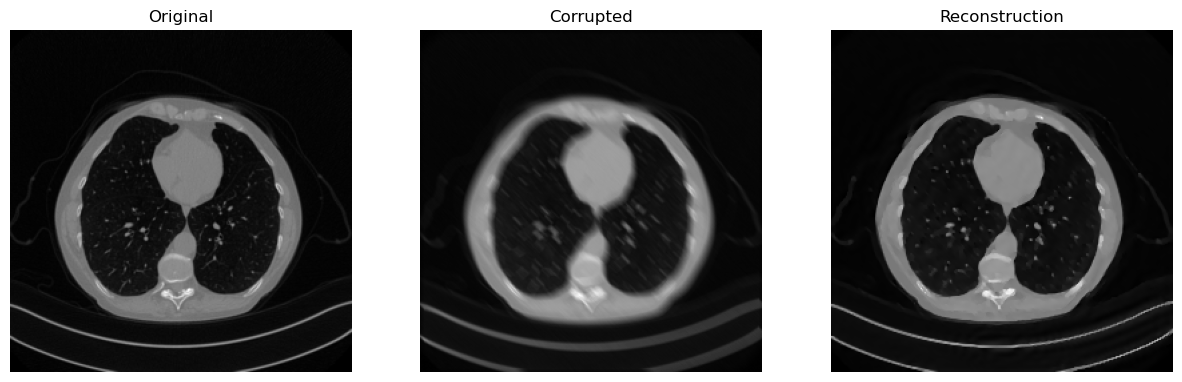

In [6]:
from IPPy import solvers, metrics

# Define the solver (e.g. ChambollePock)
solver = solvers.ChambollePockTpVUnconstrained(K) # -> takes as input the operator

# Compute solution
x_rec, _ = solver(y_delta, 
               lmbda=0.01, 
               x_true=x_true, 
               starting_point=torch.zeros_like(x_true),
               verbose=False,)

print(f"Reconstruction SSIM: {metrics.SSIM(x_rec, x_true):0.4f}.")
# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_rec.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Reconstruction')
plt.show()

## The `nn` module

We are finally ready to jump into the main topic of this course, i.e. neural networks and their use for end-to-end image reconstruction. In the remainder of this chapter, we will discuss how to implement a neural network for processing and reconstructing images with `IPPy`, with the aim of recovering the motion-blurred image from the previous example.

```{warning}
In the following we will learn how to implement a few neural network architectures, such as `CNN` or `UNet`, which we **didn't introduced yet**. For now, just threat them as general neural network used to reconstruct images. We will deeply discuss how they work in the next chapter of this course.
```

Defining a training a neural network model with `IPPy` is straightforward: just choose one of the available architecture from the `nn` module, set the parameters (or implement one yourself), and you are ready to go!

Let's see how to implement a `UNet` model for image reconstruction using `IPPy.nn`.

In [7]:
from IPPy.nn import models

# Set device
device = utilities.get_device()

# Defining neural network architecture (IGNORE now)
model = models.UNet(ch_in=1, 
                    ch_out=1,
                    middle_ch=[64, 128, 256],
                    n_layers_per_block=2,
                    down_layers=("ResDownBlock", "ResDownBlock"),
                    up_layers=("ResUpBlock", "ResUpBlock"),
                    final_activation=None)

# Send model to device
model = model.to(device)

Now we can define the data (train and test) to train our model on it.

In [8]:
# Generate train and test data
train_data = MayoDataset(data_path="../data/Mayo/train", data_shape=256)
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

And the training loop...

In [9]:
from torch import nn, optim

#--- Parameters
n_epochs = 0

loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

# Cycle over the epochs
loss_total = torch.zeros((n_epochs,))
ssim_total = torch.zeros((n_epochs,))
for epoch in range(n_epochs):

    # Cycle over the batches
    epoch_loss = 0.0
    ssim_loss = 0.0
    for t, x in enumerate(train_loader):
        # Send x and y to device
        x = x.to(device)

        # Compute associated y_delta
        y = K(x)
        y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_pred = model(y_delta)
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()

        # update loss
        epoch_loss += loss.item()
        ssim_loss += metrics.SSIM(x_pred.cpu().detach(), x.cpu().detach())

        # Infos
        print(
            f"Epoch ({epoch+1} / {n_epochs}) -> Loss = {epoch_loss / (t + 1):0.4f}, "
            + f"SSIM = {ssim_loss / (t + 1):0.4f}.",
            end="\r",
        )

    # Update the history
    loss_total[epoch] = epoch_loss / (t + 1)
    ssim_total[epoch] = ssim_loss / (t + 1)

After the model is trained, it's recommended to save the final state so that we can re-use it without waiting for the training to finish. This is done by the `trainer` module of `IPPy`, which saves both the final state of the model and a `json` file containing the specification of model architecture, so that you can re-load it afterwards.

In [10]:
from IPPy.nn import trainer

# Save model state
trainer.save(model, weights_path="../weights/")

Loading the model is straightforward. Just provide the `trainer` with the correct path and it will handle everything:

In [11]:
# Load model
model = trainer.load(weights_path="../weights/").to(device)

Now, we can test the loaded model over the test set to see how it performs

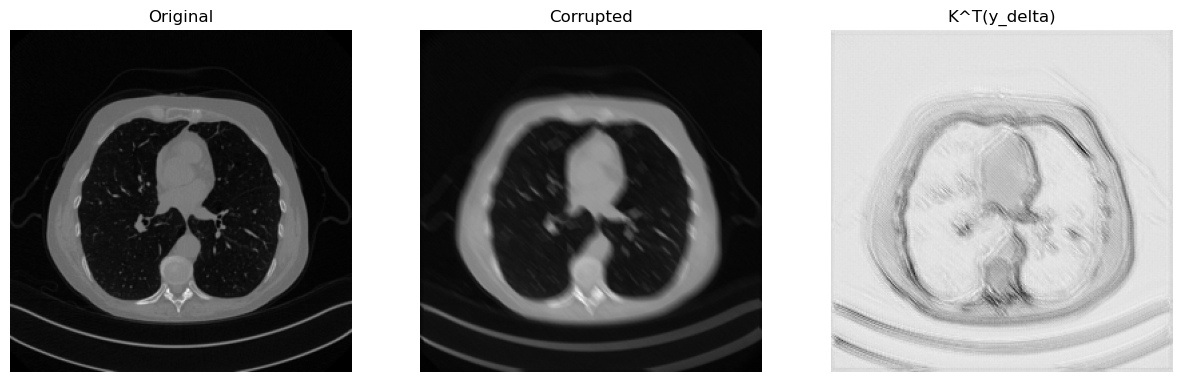

In [12]:
# Test on test data
for t, x_test in enumerate(test_loader):
    # Send to device
    x_test = x_test.to(device)

    # Compute y_delta
    y = K(x_test)
    y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

    # Predict with model (without computing the gradient to save memory)
    with torch.no_grad():
        x_pred = model(y_delta)
    
    # Visualize the input-output-prediction triplet
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[0].cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Original')

    plt.subplot(1, 3, 2)
    plt.imshow(y_delta[0].cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Corrupted')

    plt.subplot(1, 3, 3)
    plt.imshow(x_pred[0].cpu().detach().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('K^T(y_delta)')
    plt.show()
    break

Now that we learned how to implement, train and test a neural network model, we are ready to get into the details.